
![](measure_CF_calls_logo_v1.0.png)


# measure horseshoe bat calls : v1.0.0 (user-friendly and ready for you!)
Automate measurements of horseshoe bat calls - (or any similar sound!). 

### What is a horseshoe bat call - why have I never heard one before?
Don't know - no worries! Haven't heard one before? No surprise - they're literally in the ultrasonic range ($\geq$80kHz frequency).

However, if you really want to imagine what it'd be like if you could hear them, this is what a horseshoe bat call would sound like. You can do this by slowing down the horseshoe bat calls by a *lot* (10X)!

#### Just curious? Run this notebook online - without installing anything yet:
If you want to run this Jupyter Notebook online without having to install anything on your computer - head to the Binder link here and click on the *README.ipynb* file :[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/thejasvibr/measure_horseshoe_bat_calls/v1.0.0)

In [1]:
# If you're running the Jupyter notebook on mybinder or your own computer:
# Run a code/markdown cell by clicking on it and pressing Shift+Enter together
# More information on how use Jupyter Notebooks here : https://realpython.com/jupyter-notebook-introduction/#running-cells
from IPython.display import Audio, display
Audio(filename='slowed_down_call_2018-08-17_34_211.wav')

As you may have heard in the playback - the horseshoe bat call sounds like a whistle with a 'rising' part, a constant part and a 'descending' part. These are technically known as the rising frequency modulation (FM), constant frequency (CF) and the descending FM parts of a horseshoe bat call. Not all calls have both rising and descending, and some calls may have only the rising FM or the descending FM. The relative durations of the Cf and FM are also known to change depending on the behavioural context at hand. When plotted on a spectrogram, people have described the call to resemble a table (side-profile) or a staple-pin - and this is where the logo of this package comes from!

### What *is* a horseshoe bat, and why is it calling?
Horseshoe bats are a type of nocturnal bat that have strange looking noses (and thus the name) and emit the characteristic 'table-top'/'staple-pin' type echolocation calls. They emit these calls and listen for the returning echoes from these calls to detect obstacles and prey around them. 


### What does this package do and does it only work with horseshoe (Rhinolophidae) bat calls?
It's all in the name. It measures various properties of a horseshoe bat call. The package is *not* specific to only Rhinolophid bat calls! The packages is so named only because it was developed originally for two Rhinolophid species. If you have leaf-nosed(Hipposiderid) bat calls - this package should work too. 

Essentially any sound with a constant frequency flanked on either side by frequency modulations will be handled correctly! 

Given a call, the package segments out CF and FM components and calculates various measures. The FM and CF parts are separated in the waveform and various measurements are made on them including:

* CF peak frequency
* FM end frequency/ies
* CF and FM durations
* CF and FM rms and energy

### Who is this package useful for?
Mainly those studying bat calls, and in specific those analysing horseshoe/leaf-nosed bat calls. However, there may perhaps be a whole host of sounds which looks similar -- and so it might also be useful for the analysis of any sound that looks like a bat CF call!

### Why did you develop this package?
Measuring the sub-structure of horseshoe bat calls can be tiresome and error-prone when done manually. While the human eye can recognise the CF and FM parts of the call very well, segmenting it consistently is hard to do. This is because we rely on a spectrographic representation - the settings of which again influences how a call is segmented into FM and CF. Even existing automated methods in the field rely on spectrographic representations.  Moreover, to my knowledge, there aren't any  open-source tools developed specifically to measre call parameters for horseshoe bat calls. 


### Acknowledgements
The example data is a subset of audio recorded of *Rhinolophus mehelyi* and *Rhinolophus euryale* bats as they flew in and out of an evening roosting spot. Data collection was done by Neetash MR and Thejasvi Beleyur. Audio data annotation and selection done by Aditya Krishna. 

I thank Neetash MR, Diana Schoeppler & Holger R Goerlitz for their inputs in the development of this package.

### How do I use this package?

### Installation: 
This package works with both Python 2 and 3. 
Download the package using pip with:

```pip install measure_horseshoebat_calls ```

or

download this repo from Github,open up a terminal window, navigate to the folder,  and type:

```python setup.py install ```

### Usage:

The measure_horseshoe_bat_calls package takes in an audio file snippet with a *single* horseshoe bat call in it and outputs various measures of this call. Let us first load a manually selected part of a recording with a single horseshoe bat call in it. 

In [2]:
# import package and required modules
%matplotlib notebook
import measure_horseshoe_bat_calls
from measure_horseshoe_bat_calls import measure_a_horseshoe_bat_call as measure
from measure_horseshoe_bat_calls import segment_horseshoebat_call as segment
from measure_horseshoe_bat_calls.view_horseshoebat_call import *
from measure_horseshoe_bat_calls import data


<IPython.core.display.Javascript object>


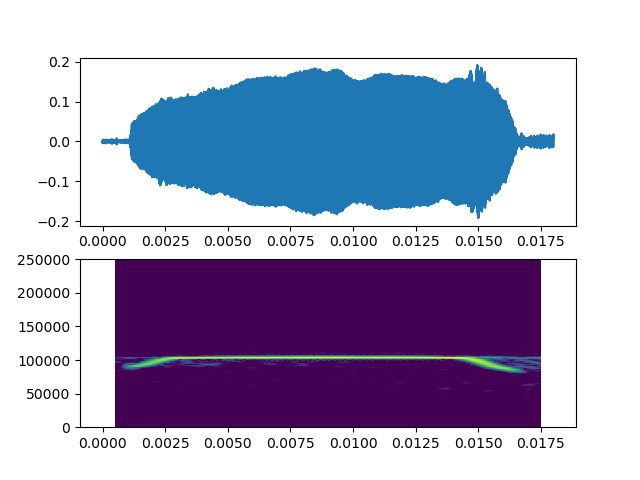

(<matplotlib.axes._subplots.AxesSubplot at 0x11eebcc8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14f15f88>)

In [3]:
# load a short audio file with manually annotated data 
chosen_audio = data.example_calls[25]
fs = data.fs

# view the waveform + spectrogram
visualise_call(chosen_audio, fs)

### Segmenting the call from the silent background. 
Measuring temporal features such as call, CF and FM durations relies on an accurate and tight window selection that includes the call without too much of the background. Having more 'background' in the analyses will lead to inaccurate measurements of all parameters eg. duration and rms. Selecting a tight window can be simply done by hand, but also yields inconsistent results each time. Automating this process allows reproducibility across time. 

In [4]:
# get a tight window which only has the call. 
main_call_window, call_profile = segment.segment_call_from_background(chosen_audio, fs, 
                                                                          background_threshold=-20)

<IPython.core.display.Javascript object>


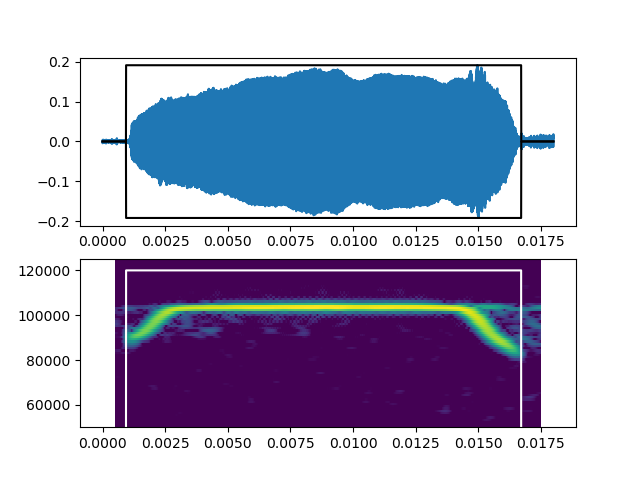

(50000, 125000)

In [5]:
waveform, specgram = check_call_background_segmentation(chosen_audio, fs, main_call_window)
# choose a tighter ylim to see the call better
specgram.set_ylim(50000, 125000)

### Segmenting a horseshoe bat call into the FM and CF components:
To actually quantitatively characterise a horseshoe bat call we first need to define the constant frequency (CF) and frequency modulated (FM) parts of it. 

In [6]:
# choose only the call without any background
only_call = chosen_audio[main_call_window]

In [7]:
cf, fm, info = segment.segment_call_into_cf_fm(only_call, fs, percentage_peak=0.99)

<IPython.core.display.Javascript object>


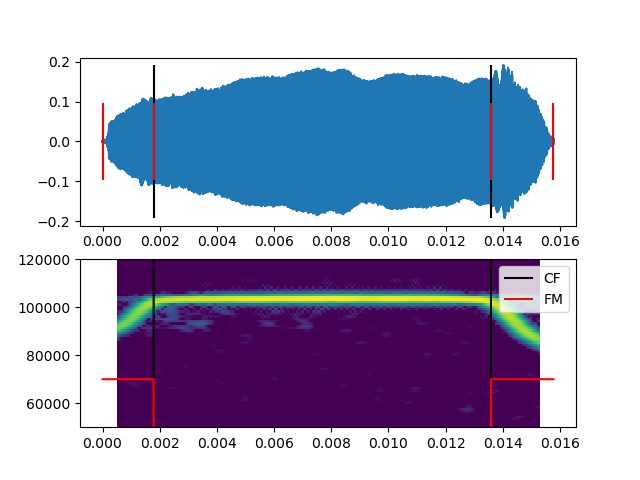

(50000, 120000)

In [8]:
wave, spec = check_call_parts_segmentation(only_call, fs, cf, fm)
spec.set_ylim(50000, 120000)

### Segmenting the call into CF and FM parts


In [9]:
call_parts, measurements = measure.measure_hbc_call(only_call, fs, cf, fm)

<IPython.core.display.Javascript object>


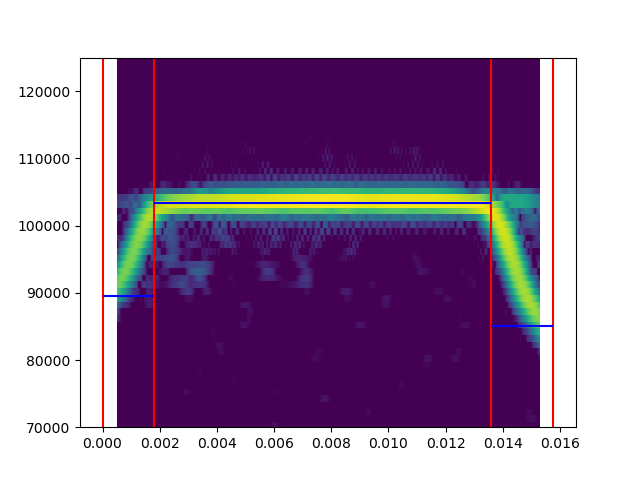

(70000, 125000)

In [10]:
spec = make_overview_figure(only_call, fs, measurements)
spec.set_ylim(70000, 125000)

### Understanding the measurements and overview figure:
The plot above shows start and stop times of the FMs in red. The blue lines along the FM indicate the lowest frequency (at -X dB threshold) and are drawn over the duration of the entire FM segment. The blue line in the CF is drawn at the call peak frequency and is drawn over the duration of the CF portion. 

In [11]:
measurements

{'call_duration': 0.015774,
 'call_energy': 82.03420564756195,
 'call_rms': 0.10198623706522475,
 'peak_frequency': 103397.99670343605,
 'cf_start': 0.001786,
 'cf_end': 0.013586,
 'cf_duration': 0.011802,
 'cf_energy': 70.5245541075025,
 'cf_rms': 0.10932194936686337,
 'cf_peak_frequency': 103372.30977800372,
 'downfm_duration': 0.002186,
 'downfm_energy': 8.692437077021436,
 'downfm_rms': 0.08917860958299324,
 'downfm_terminal_frequency': 85086.91674290942,
 'downfm_start': 0.013588,
 'downfm_end': 0.015772,
 'upfm_duration': 0.001786,
 'upfm_energy': 2.8172144630380025,
 'upfm_rms': 0.05616738764205647,
 'upfm_terminal_frequency': 89585.66629339306,
 'upfm_start': 0.0,
 'upfm_end': 0.001784,
 'terminal_frequency_threshold': -10}

### The call parts : CF and FM 
The output sounds are the audio corresponding to the CF segmentation and FM segmentation. The call parts are output as a list with two objects in them. The first is the CF sound, and the second is another list with one or two FM sounds in it. 

<IPython.core.display.Javascript object>


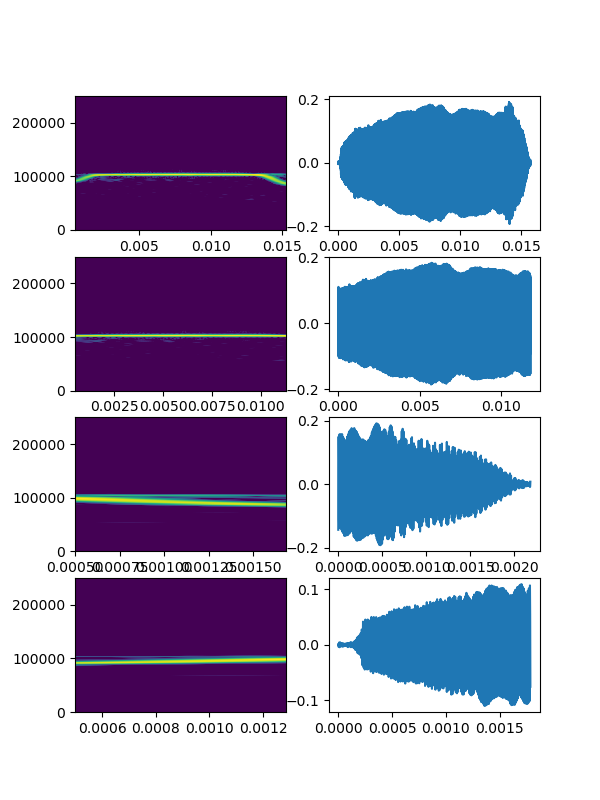

In [12]:
show_all_call_parts(only_call, call_parts, fs)


### Choosing the right parameter settings for *your* bat calls!
The segmentation is of course affected by the parameter settings given to ```measure_hbc_call ```. The current default set may be good for many situations - but you may want better! 

### Under the hood : how does the horseshoe bat call segmentation actually work?
The call segmentation works on the fact that horseshoe bat calls have a relatively stereotyped structure. The CF part of a call is typically flanked by one or two FMs. ```segment_call_into_cf_fm ``` goes through the following steps for every input audio. 

#### 1. Call-background segmentation:
Separate call from background by running a continuous wavelet transform on the audio. The coefficients of all scales with centre frequencies in the signal range are summed up. This forms a kind of the calls 'energy profile' - but only within the relevant frequencies. This approach tracks the onset and offset of the signal with high temporal resolution. 

<IPython.core.display.Javascript object>


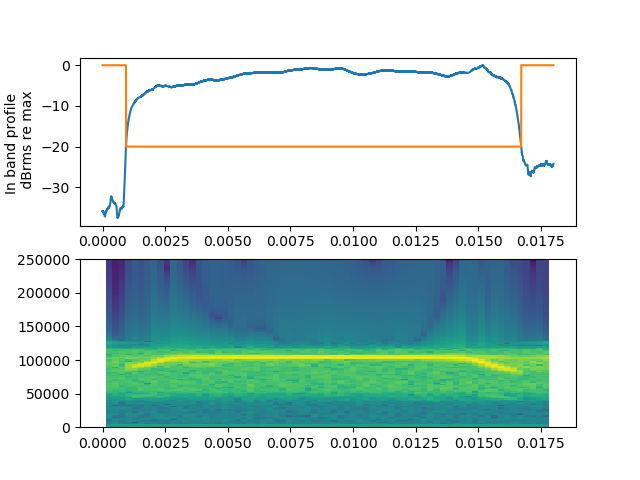

In [13]:
main_call_window, call_profile = segment.segment_call_from_background(chosen_audio, fs, 
                                                                          background_threshold=-20)
plt.figure()
a0 =plt.subplot(211)
make_waveform(call_profile, fs)
make_waveform(main_call_window*-20,fs) # show the region above the threshold
plt.ylabel('In band profile \n dBrms re max')
plt.subplot(212, sharex=a0)
plt.specgram(chosen_audio, Fs=fs);

In [14]:
# remove background
narrow_call_selection = chosen_audio[main_call_window]

#### 2. Form FM dominant and CF dominant versions of the call:
Separate FM and CF by forming two versions of the call filtered at the same threshold frequency: i) low-pass filtered ii) high-pass filtered. The threshold frequency for low and high pass filtering is user-definable, and set by default to 0.99 of the detected peak frequency.
#### 3. Calculate a running dB rms profile for both version and detect regions which are relatively amplified.
A dB rms profile of the low and high pass filtered audio is calculated. The main idea is that the low pass dBrms profile will have peaks towards the edges (where the FM sweeps are), while the highpass dBrms profile will have a broad bump in the centre. How to separate out the two reliably? The separation is done by taking a difference profile. eg. The portions of the $lowpass_{dB \:rms}-highpass_{dB \:rms}$ difference profile which are $\geq 1$ are the FM parts, while the portions of the $highpass_{dB \:rms}-lowpass_{dB \:rms} >0 $ are the CF parts.

Both steps 2 and 3 are done in the function ```pre_process_for_segmentation```


<IPython.core.display.Javascript object>


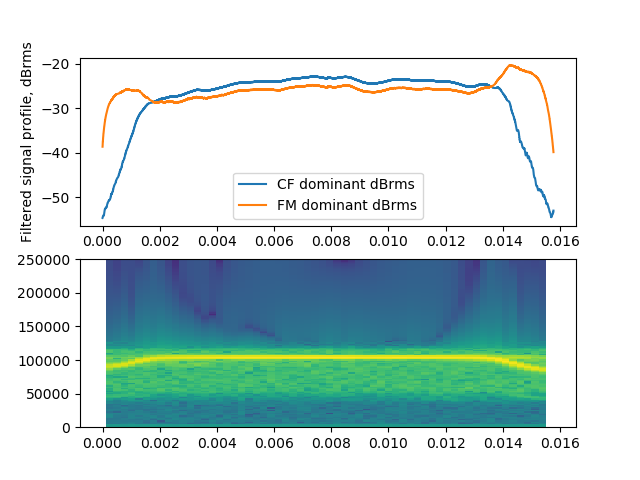

In [15]:
# calculate dB rms profile for low-passed and high-passed audio
cf_dbrms, fm_dbrms = segment.pre_process_for_segmentation(narrow_call_selection, fs)

plt.figure()
b0 = plt.subplot(211)
plt.plot(make_x_time(cf_dbrms, fs), cf_dbrms, label='CF dominant dBrms')
plt.plot(make_x_time(fm_dbrms, fs), fm_dbrms, label='FM dominant dBrms')
plt.ylabel('Filtered signal profile, dBrms')
plt.legend()
plt.subplot(212, sharex=b0)
plt.specgram(narrow_call_selection, Fs=fs);

In [16]:
# subtract the two from each other and see which regions they are relatively higher than the other.
main_cf, main_fm, [cf_re_fm, fm_re_cf] = segment.segment_cf_and_fm(cf_dbrms, fm_dbrms, fs)

The regions where the CF profile (re FM profile) are $\geq$0 -- are labelled as CF, and those where the FM profile (re. CF profile) are $\geq$0 are labelled as FM. The current implementation can handle either one or two FM segments in a call, and cannot handle a call with 0 or $\geq$2 FM segments!

<IPython.core.display.Javascript object>


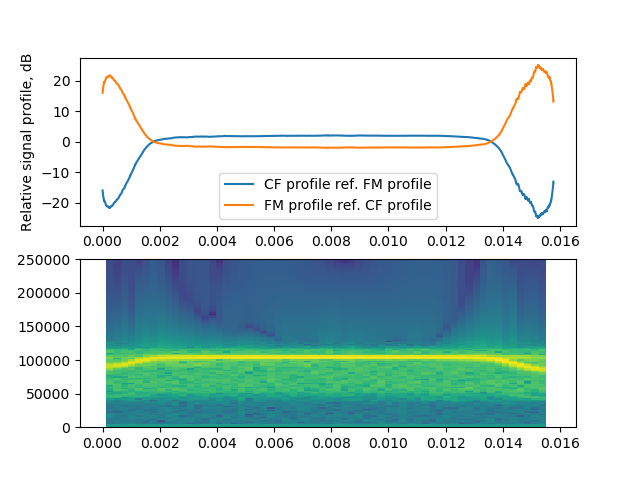

In [17]:
plt.figure()
c0 = plt.subplot(211)
plt.plot(make_x_time(cf_re_fm, fs), cf_re_fm, label='CF profile ref. FM profile')
plt.plot(make_x_time(fm_re_cf, fs), fm_re_cf, label='FM profile ref. CF profile')
plt.ylabel('Relative signal profile, dB')
plt.legend()
plt.subplot(212, sharex=c0)
plt.specgram(narrow_call_selection, Fs=fs);

To Add in README (Coming Soon...):
1) Run through different example calls, and what parameters can be altered to improve:
* 1a) call-background segmentation - background_threshold, background_frequency
* 1b) call-part segmentation - peak-percentage, rms window size calculations

2) Viewing/plotting options


### Feedback and Contributions Welcome!! 
If you think you have some vocalisations/sounds that look like a horseshoe bat call on a spectrogram, and you think it's not being analysed quite right yet - do write to me with example data, I'd be happy to look into it. 


### Author: Thejasvi Beleyur,   Acoustic and Functional Ecology Group, Max Planck Institute for Ornithology, Seewiesen

-- Last updated 2020-03-13